In [1]:
import pandas as pd
import os
import librosa
import pickle
import librosa
import numpy as np

from sklearn.metrics import f1_score,precision_score,recall_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from datetime import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def read_serialized_file(file_path):
#   directory = '/kaggle/working/' + file_path # Change 'directory' Accordingly
  directory = file_path 
  infile = open(directory,'rb')
  loaded_data = pickle.load(infile)
  infile.close()
  return loaded_data

In [3]:
def generate_mel_spec(audio):
  mel = librosa.power_to_db(librosa.feature.melspectrogram(y=audio, sr=22050, n_mels=128, n_fft=2048, hop_length=512))
  return mel

def generate_mfcc(audio):
  mfcc = librosa.feature.mfcc(y=audio, n_mfcc=128, n_fft=2048, hop_length=512)
  return mfcc

def generate_chroma(audio):
  chroma = librosa.feature.chroma_stft(y=audio, sr=22050, n_chroma=128, n_fft=2048, hop_length=512)
  return chroma

In [4]:
def create_features():
  labelled_features = []

#   audio_array = read_serialized_file("label_enc_audio_aug.pkl")
  audio_array = read_serialized_file("/kaggle/input/healthy-and-abnormal-lung-sounds/label_enc_audio_binary_norm.pkl")

  for raw_audio, label,file in audio_array:
    melsp = generate_mel_spec(raw_audio)
    mfcc = generate_mfcc(raw_audio)
    chroma = generate_chroma(raw_audio)

    three_chanel = np.stack((melsp, mfcc, chroma), axis=2)

    labelled_features.append([three_chanel, label, file])

  print(len(labelled_features))

  return labelled_features

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def get_classification_result(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_0_accuracy = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    class_1_accuracy = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    
    print(f"Class 0 Accuracy: {class_0_accuracy:.4f}")
    print(f"Class 1 Accuracy: {class_1_accuracy:.4f}")
    print()
    
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

In [7]:
stacked_labeled_features = create_features()

/opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


1936


In [8]:
stacked_features_path = '/kaggle/working/stacked_specs_binary_norm.pkl'
with open(stacked_features_path, "wb") as file:
    pickle.dump(stacked_labeled_features, file)

In [9]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten,  BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD

from keras import callbacks
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, max_epochs=80):  # Add max_epochs as a parameter
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch[:max_epochs], history.history[metric][:max_epochs], color=colors[0], label='Train')  # Limit the data to the first 80 epochs
    plt.plot(history.epoch[:max_epochs], history.history['val_'+metric][:max_epochs],
             color='orange', label='Val')  # Limit the data to the first 80 epochs
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      ylim_max = 1.05  # Adjust the padding value as needed
      plt.ylim([0, ylim_max])
      y_ticks = np.arange(0, ylim_max, 0.2)  # Define y-axis ticks with 0.1 increments
      plt.yticks(y_ticks)
    plt.grid(linestyle='--', linewidth=0.5, color='gray')
    plt.legend()

In [11]:
stacked_spects = read_serialized_file("/kaggle/working/stacked_specs_binary_norm.pkl")
feature_data = pd.DataFrame(stacked_spects,columns=['feature','class','file'])

In [12]:
files_to_remove = [980,1181,1186,1353,1393,1413,1776,1786]
mask = feature_data['file'].isin(files_to_remove)
feature_data_filtered = feature_data[~mask]

In [13]:
X = np.array(feature_data_filtered['feature'].tolist())
y = np.array(feature_data_filtered['class'].tolist())
f = np.array(feature_data_filtered['file'].tolist())

In [14]:
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

X_test, X_validate, y_test, y_validate = train_test_split(X_,y_,test_size=0.5,random_state=42, stratify=y_)

In [15]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(X_validate))

(1542, 128, 264, 3)
(193, 128, 264, 3)
(193, 128, 264, 3)


In [16]:
input_shape = (128, 264, 3)

In [17]:
train_values = [np.count_nonzero(y_train == i) for i in np.unique(y_train)]
print(train_values)

[780, 762]


In [18]:
print(y_train)

[1 0 1 ... 1 0 0]


In [21]:
disease_stats = [780, 762]
min_value = min(disease_stats)

weights = [min_value / value for value in disease_stats]
class_weights = {label: weight for label, weight in enumerate(weights)}
sample_weight=np.array([class_weights[label] for label in y_train])

In [98]:
def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 264, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [104]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 126, 262, 32)      896       
                                                                 
 max_pooling2d_66 (MaxPooli  (None, 63, 131, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_70 (Conv2D)          (None, 61, 129, 32)       9248      
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 30, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_71 (Conv2D)          (None, 28, 62, 64)        18496     
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 14, 31, 64)      

In [99]:
model = create_model()
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 12, restore_best_weights = True, verbose=1)
baseline_history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_validate, y_validate), callbacks =[earlystopping], sample_weight=sample_weight)

Epoch 1/100
49/49 [==============================] - 4s 27ms/step - loss: 0.7701 - accuracy: 0.5376 - val_loss: 0.6274 - val_accuracy: 0.6580
Epoch 2/100
49/49 [==============================] - 1s 20ms/step - loss: 0.6584 - accuracy: 0.6018 - val_loss: 0.7116 - val_accuracy: 0.5751
Epoch 3/100
49/49 [==============================] - 1s 19ms/step - loss: 0.6026 - accuracy: 0.6647 - val_loss: 0.6234 - val_accuracy: 0.6062
Epoch 4/100
49/49 [==============================] - 1s 19ms/step - loss: 0.6238 - accuracy: 0.6304 - val_loss: 0.5668 - val_accuracy: 0.6891
Epoch 5/100
49/49 [==============================] - 1s 19ms/step - loss: 0.5445 - accuracy: 0.7043 - val_loss: 0.5701 - val_accuracy: 0.6891
Epoch 6/100
49/49 [==============================] - 1s 19ms/step - loss: 0.5305 - accuracy: 0.7140 - val_loss: 0.5456 - val_accuracy: 0.7047
Epoch 7/100
49/49 [==============================] - 1s 19ms/step - loss: 0.5234 - accuracy: 0.7043 - val_loss: 0.5322 - val_accuracy: 0.7409
Epoch 

In [101]:
get_classification_result(model, X_test, y_test)

7/7 [==============================] - 0s 6ms/step
Overall Accuracy: 0.9016
Class 0 Accuracy: 0.8557
Class 1 Accuracy: 0.9479

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90        97
           1       0.87      0.95      0.91        96

    accuracy                           0.90       193
   macro avg       0.90      0.90      0.90       193
weighted avg       0.91      0.90      0.90       193



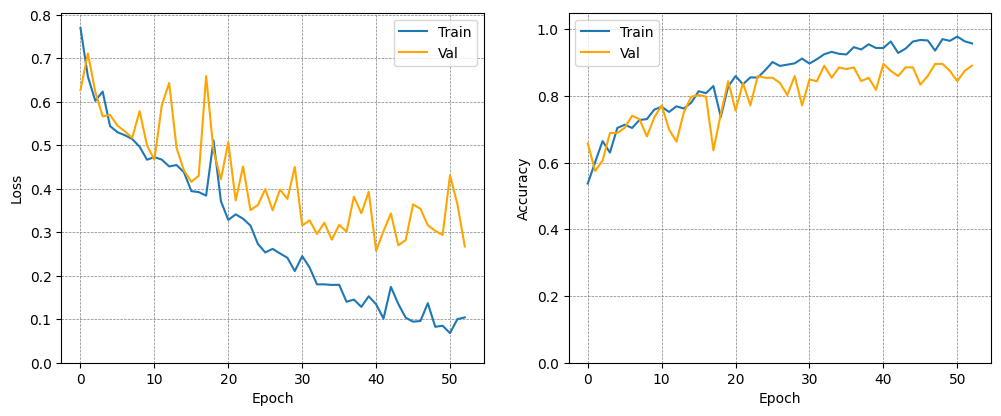

In [102]:
plot_metrics(baseline_history, 100)

In [106]:
import joblib

joblib.dump(model, '/kaggle/working/binary_model.joblib')

['/kaggle/working/binary_model.joblib']